District and sector data saved to 'outputs/rwanda_districts_data.json'
Dataset Preview:
   district             sector  latitude  longitude      soil_type crop_type  \
0  Bugesera  Bugesera-Sector-2 -1.725670  29.736249     Loamy Sand    Coffee   
1   Gatsibo   Gatsibo-Sector-5 -1.743848  30.827036     Silty Clay      Rice   
2  Gisagara  Gisagara-Sector-3 -1.520807  29.032871     Silty Clay     Beans   
3   Musanze   Musanze-Sector-2 -1.812279  30.252980  Volcanic Soil     Maize   
4   Rutsiro   Rutsiro-Sector-4 -1.145592  29.331279     Sandy Loam       Tea   

   planting_year planting_season  field_size_ha  elevation_m  ...  \
0           2015               B       2.371008  2204.104175  ...   
1           2015               C       5.598774  1294.935869  ...   
2           2015               A       5.188496  2969.786377  ...   
3           2015               B       3.367985  2056.082643  ...   
4           2015               A       3.494976  2333.384369  ...   

   max_temperatu

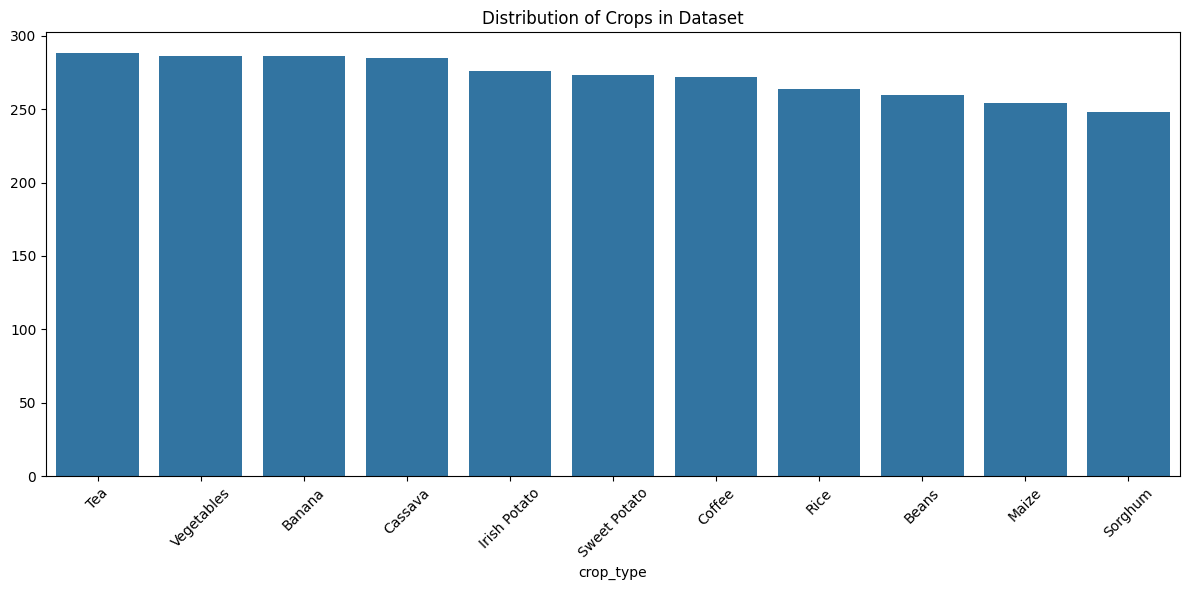

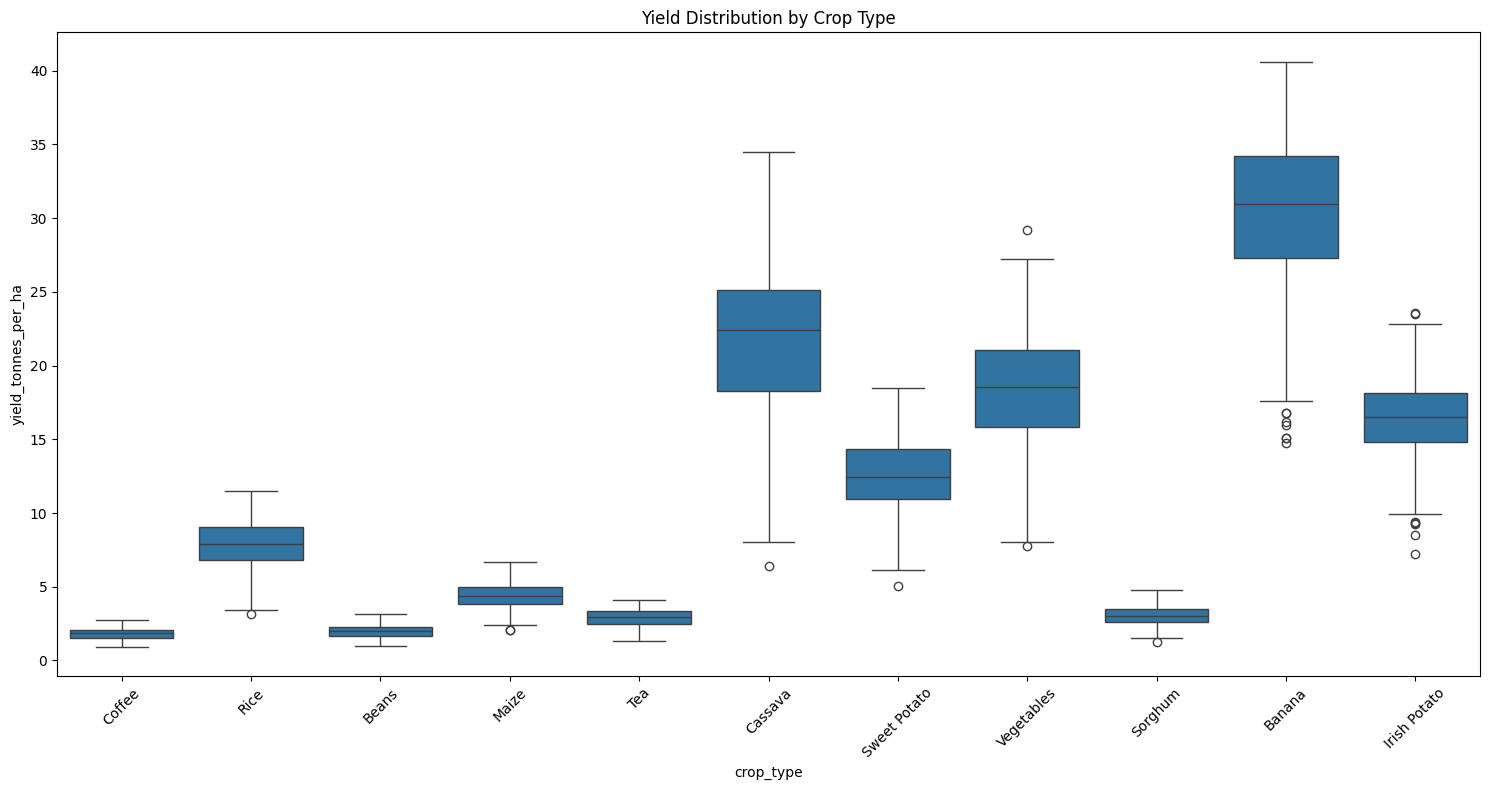

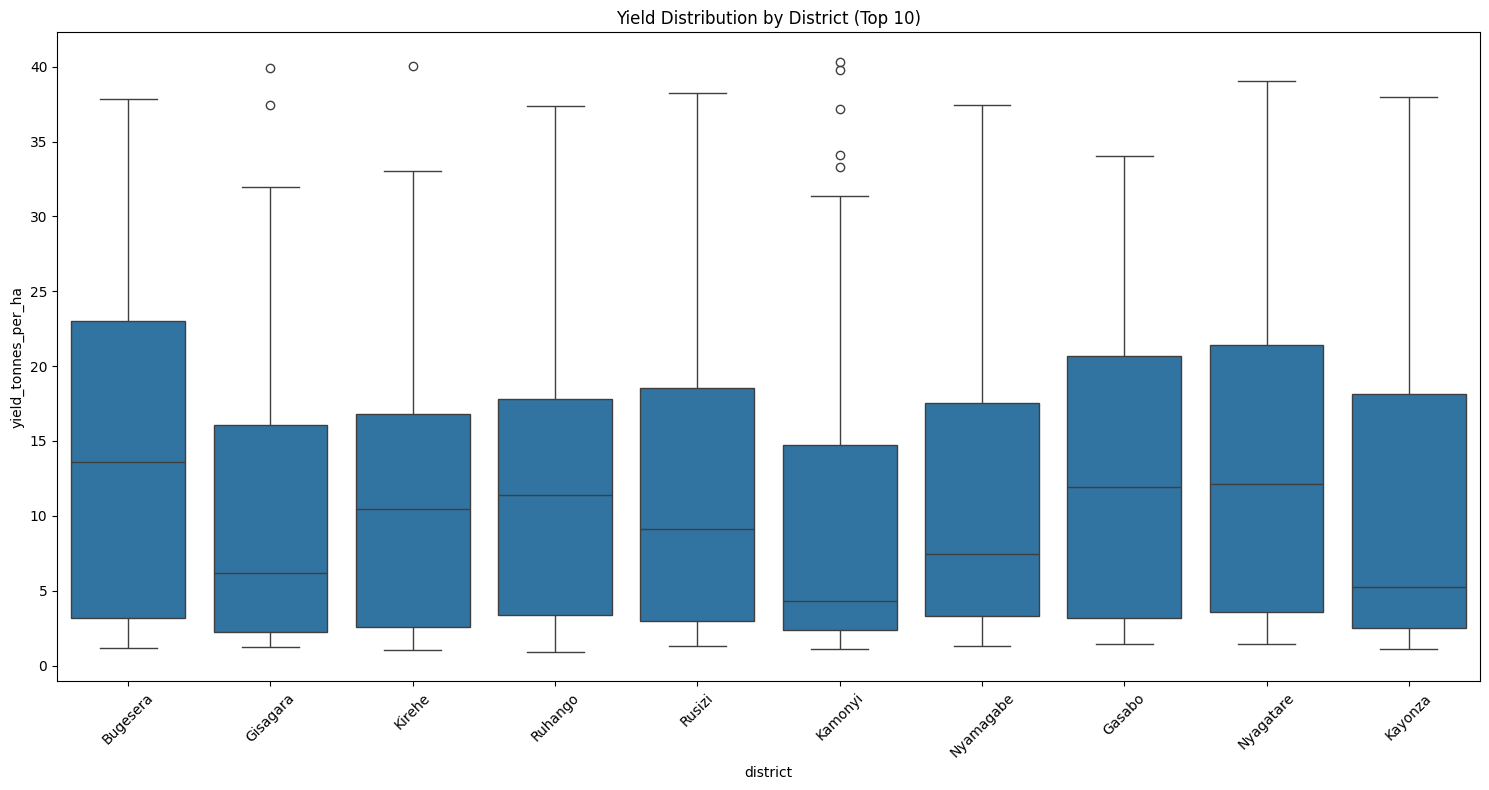

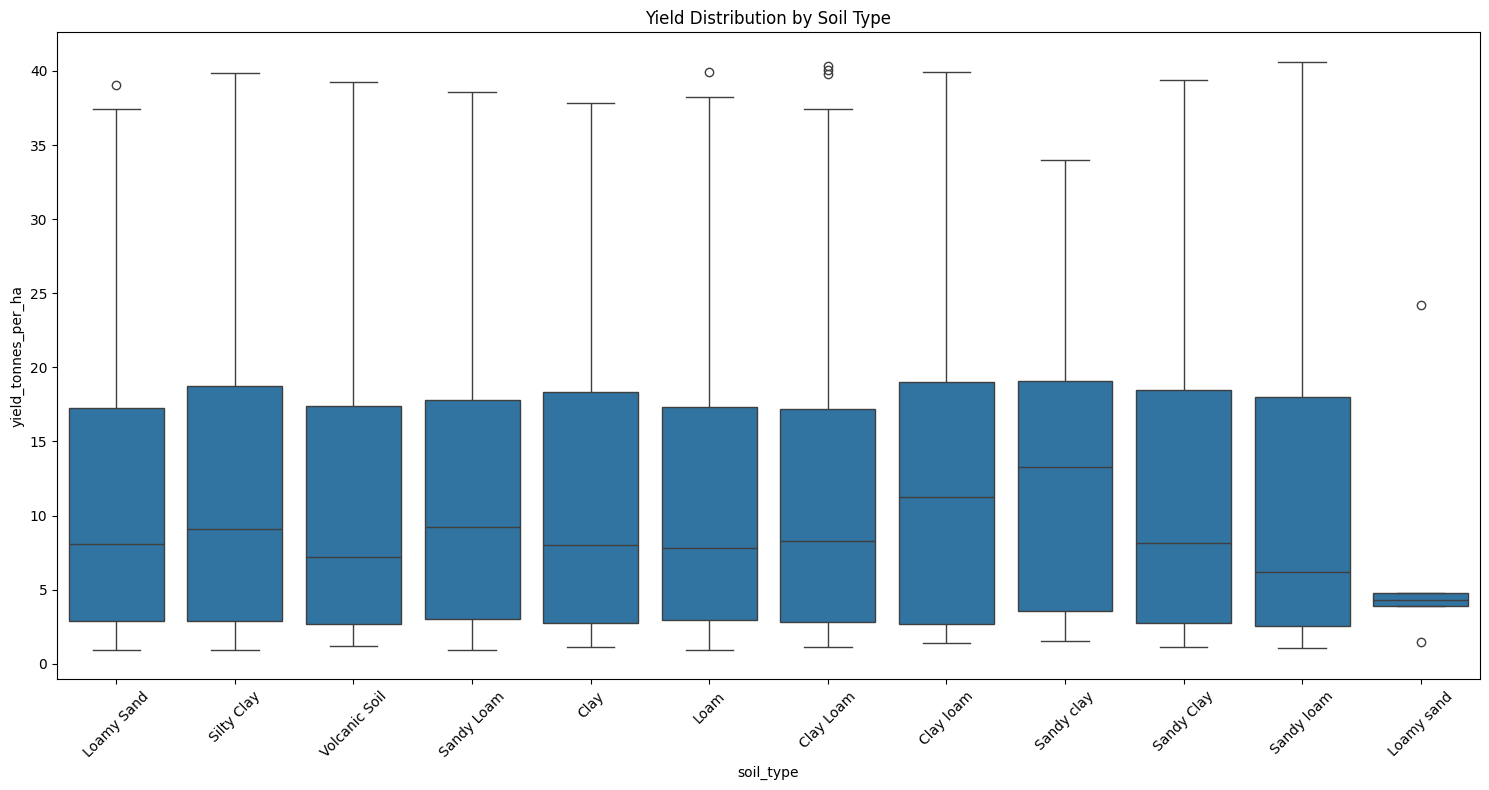

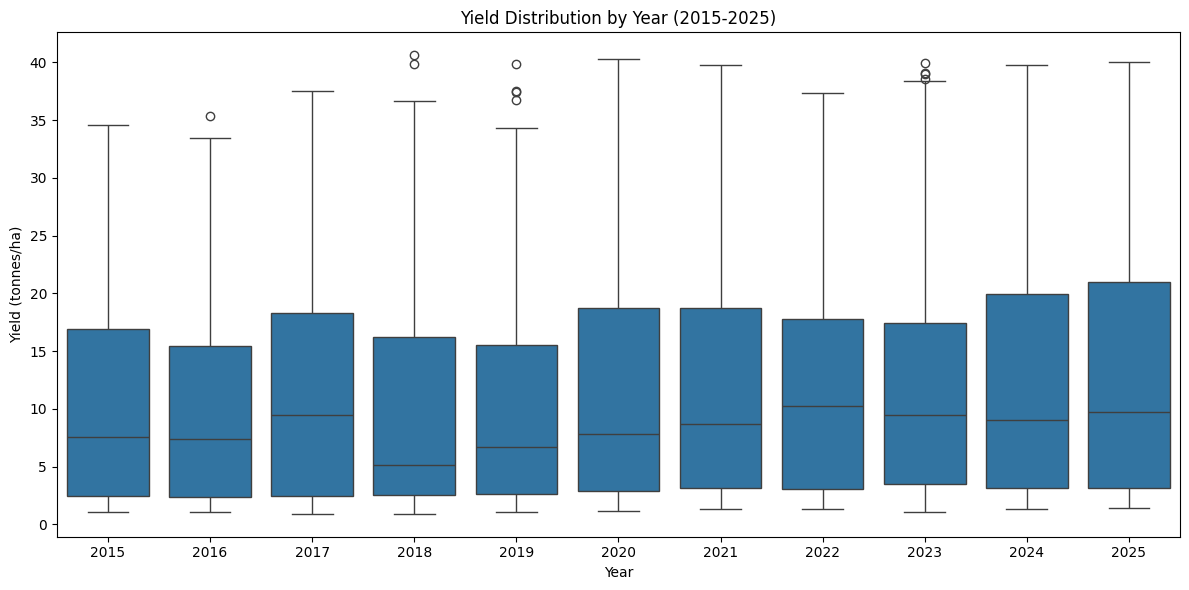

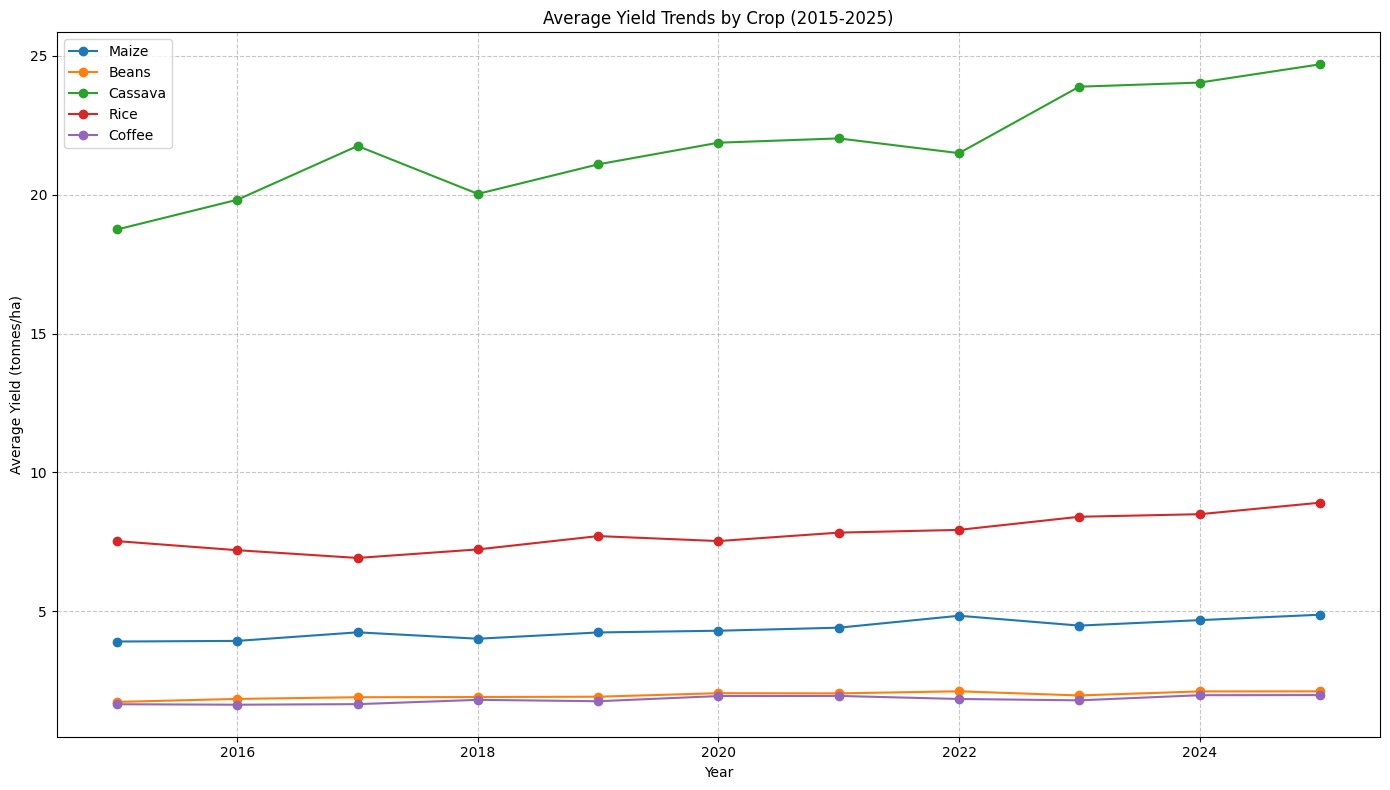

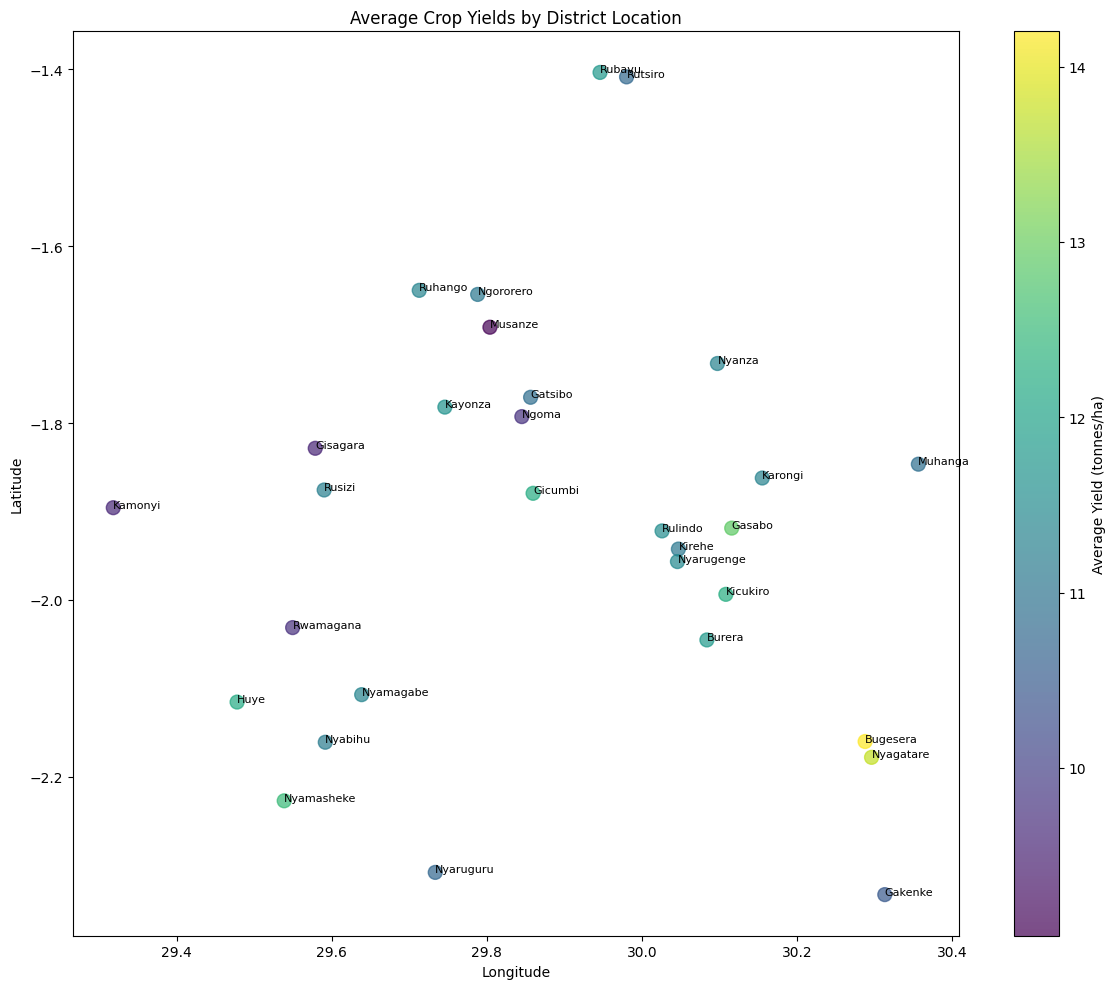

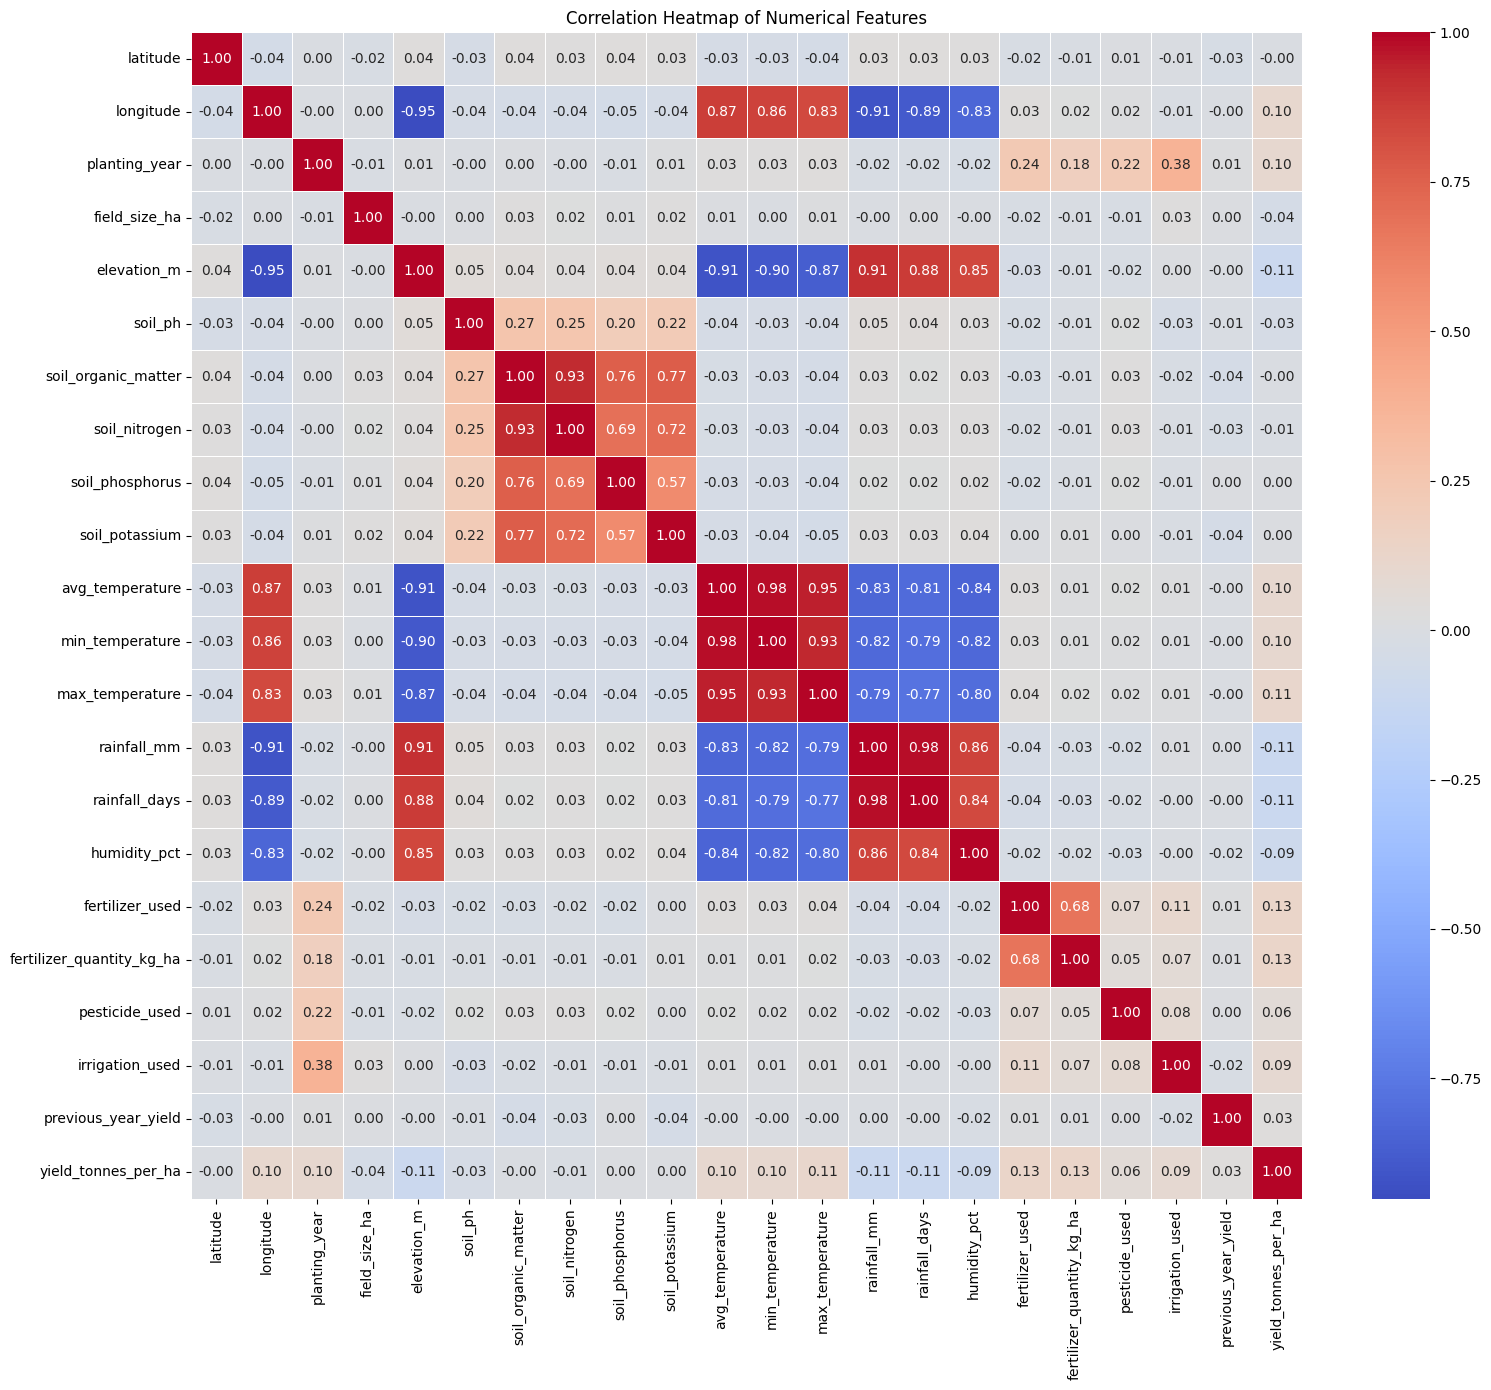

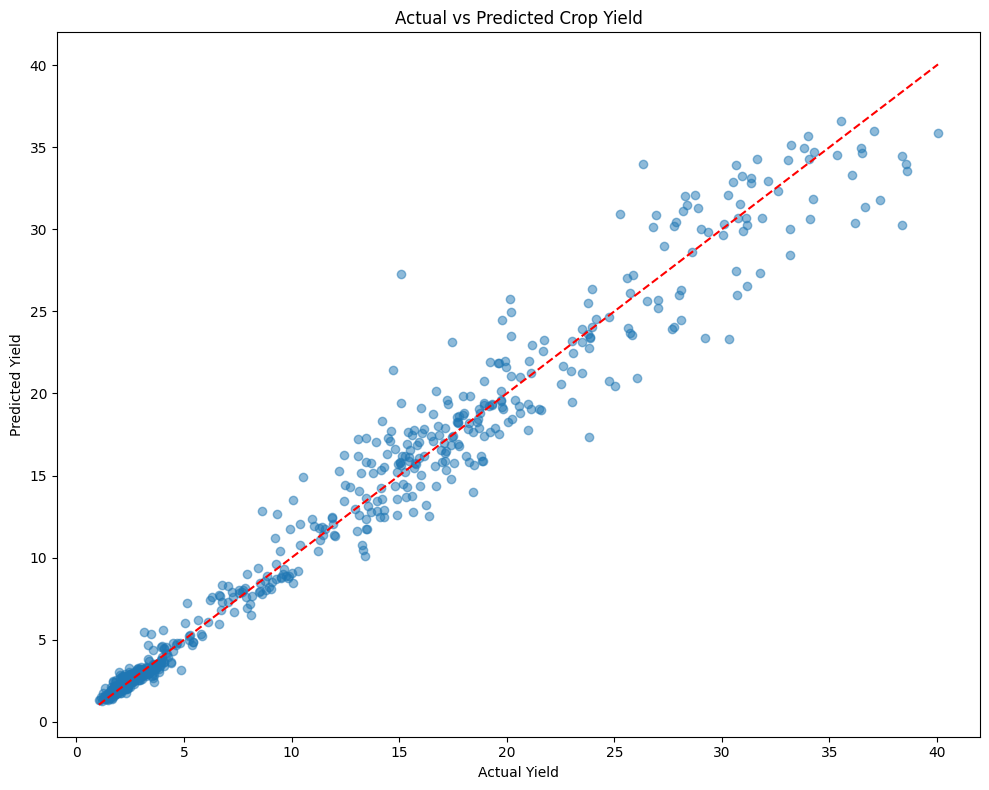

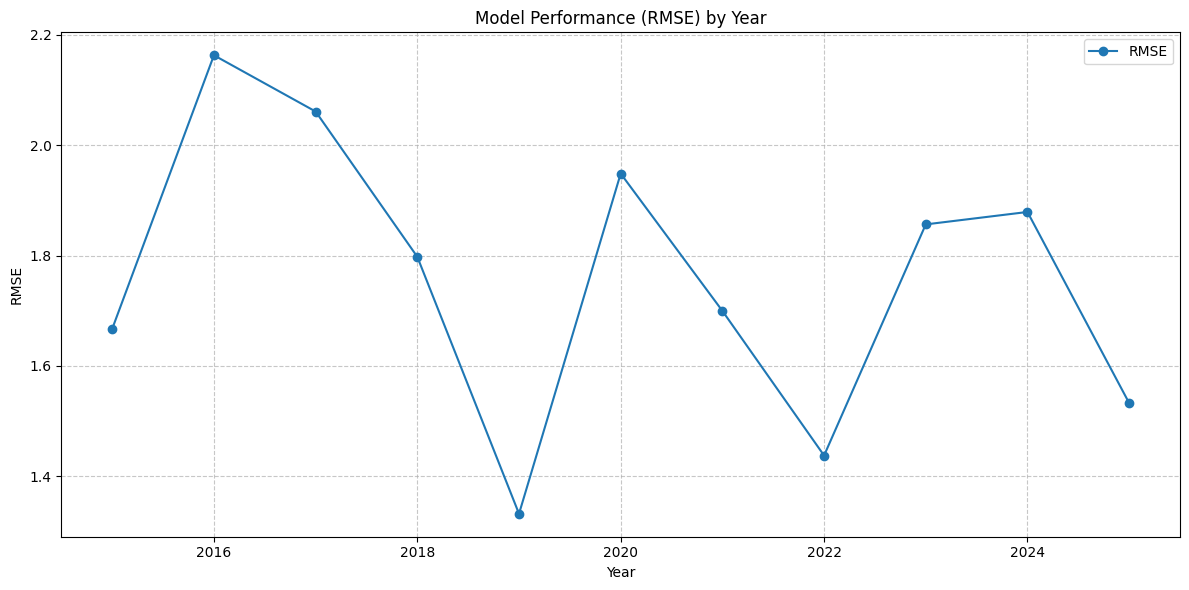

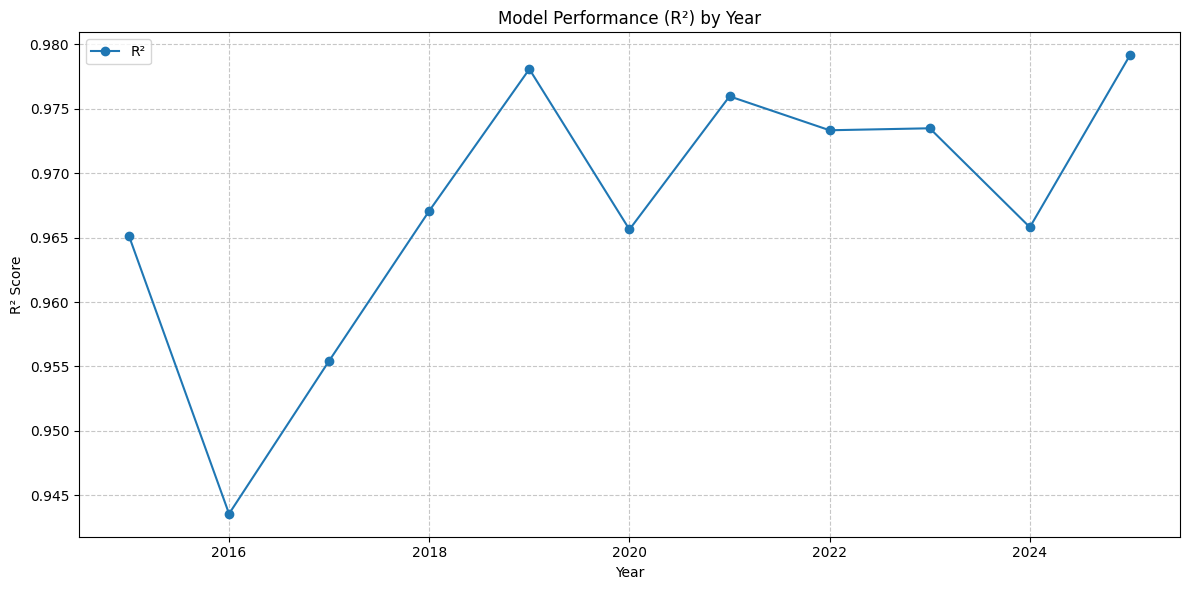

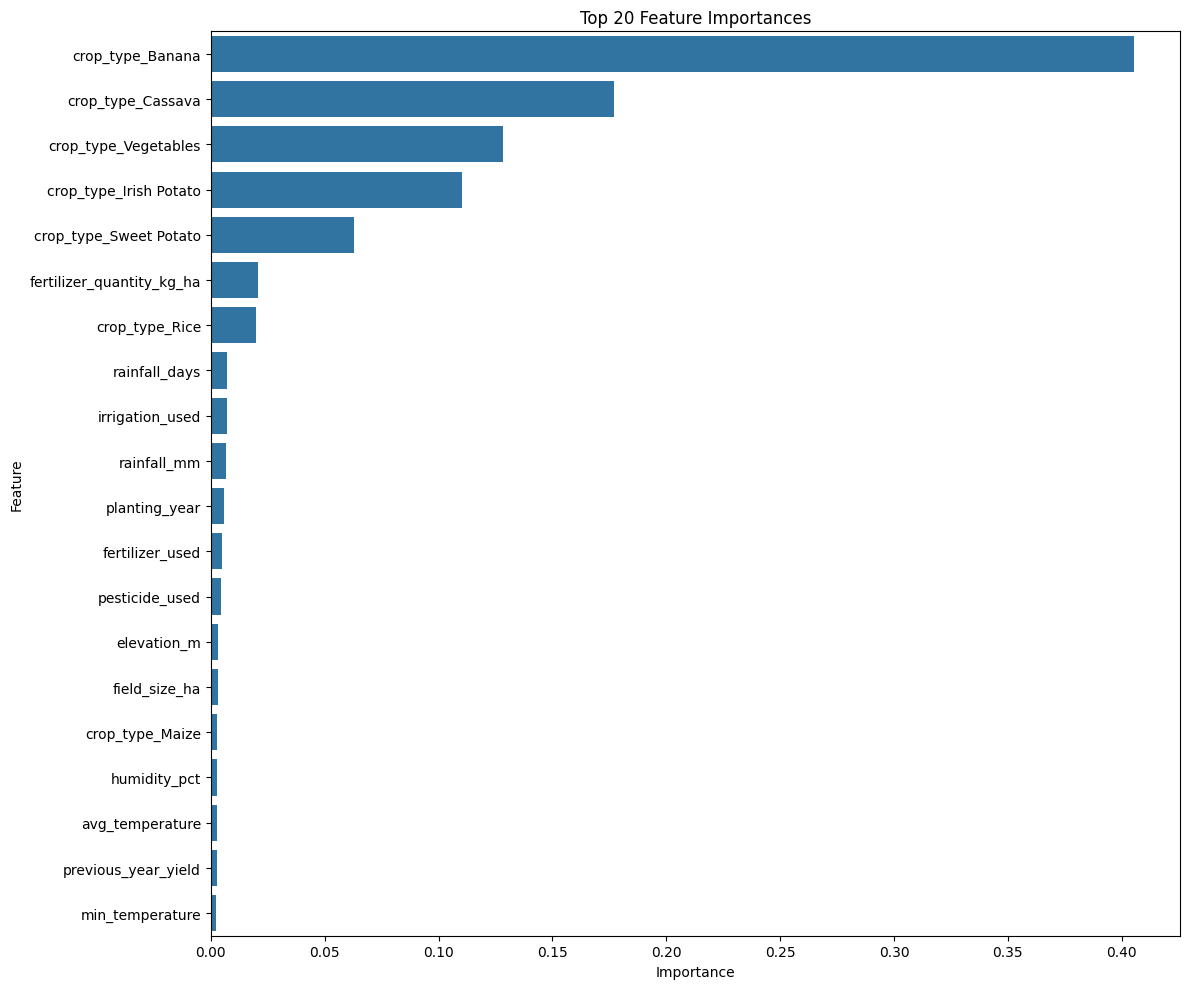

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import os
import json

# Set random seed for reproducibility
np.random.seed(42)

# Create directory for outputs if it doesn't exist
os.makedirs('outputs', exist_ok=True)

# Rwanda's districts and sectors data with coordinates and soil types
districts_data = {
    'Nyarugenge': {
        'sectors': [
            ('Gitega', -1.9547, 30.0574, 'Clay loam'),
            ('Kanyinya', -1.9425, 30.0234, 'Sandy clay'),
            ('Kigali', -1.9494, 30.0588, 'Clay'),
            ('Kimisagara', -1.9569, 30.0397, 'Sandy loam'),
            ('Mageragere', -1.9872, 30.0089, 'Clay loam'),
            ('Muhima', -1.9436, 30.0614, 'Sandy clay'),
            ('Nyakabanda', -1.9647, 30.0397, 'Clay'),
            ('Nyamirambo', -1.9750, 30.0397, 'Sandy loam'),
            ('Nyarugenge', -1.9508, 30.0556, 'Clay loam'),
            ('Rwezamenyo', -1.9494, 30.0556, 'Clay')
        ]
    },
    'Gasabo': {
        'sectors': [
            ('Bumbogo', -1.8897, 30.1147, 'Sandy clay'),
            ('Gatsata', -1.9178, 30.0672, 'Clay loam'),
            ('Gikomero', -1.8794, 30.1969, 'Sandy loam'),
            ('Gisozi', -1.9289, 30.0839, 'Clay'),
            ('Jabana', -1.8961, 30.0506, 'Sandy clay'),
            ('Jali', -1.8897, 30.1672, 'Clay loam'),
            ('Kacyiru', -1.9447, 30.0922, 'Loamy sand'),
            ('Kimihurura', -1.9536, 30.0922, 'Clay'),
            ('Kimironko', -1.9494, 30.1191, 'Sandy loam'),
            ('Kinyinya', -1.9178, 30.1017, 'Clay loam'),
            ('Ndera', -1.9178, 30.1672, 'Sandy clay'),
            ('Nduba', -1.8794, 30.1372, 'Clay'),
            ('Remera', -1.9557, 30.1097, 'Clay loam'),
            ('Rusororo', -1.9289, 30.1447, 'Sandy loam'),
            ('Rutunga', -1.8897, 30.1447, 'Clay')
        ]
    },
    'Kicukiro': {
        'sectors': [
            ('Gahanga', -2.0247, 30.1017, 'Sandy clay'),
            ('Gatenga', -1.9872, 30.0922, 'Clay loam'),
            ('Gikondo', -1.9750, 30.0756, 'Sandy loam'),
            ('Kagarama', -1.9935, 30.0922, 'Clay'),
            ('Kanombe', -1.9750, 30.1286, 'Sandy clay'),
            ('Kigarama', -2.0006, 30.1156, 'Clay loam'),
            ('Masaka', -2.0247, 30.1447, 'Sandy loam'),
            ('Niboye', -1.9872, 30.1097, 'Clay'),
            ('Nyarugunga', -1.9935, 30.1286, 'Sandy clay'),
            ('Kicukiro', -1.9700, 30.1000, 'Loam')
        ]
    },
    'Bugesera': {
        'sectors': [
            ('Gashora', -2.1733, 30.2500, 'Sandy clay'),
            ('Juru', -2.1347, 30.2225, 'Clay loam'),
            ('Kamabuye', -2.1153, 30.2500, 'Sandy loam'),
            ('Mareba', -2.1347, 30.2775, 'Clay'),
            ('Mayange', -2.1541, 30.2225, 'Sandy clay'),
            ('Musenyi', -2.1153, 30.2775, 'Clay loam'),
            ('Mwogo', -2.1733, 30.2225, 'Sandy loam'),
            ('Ngeruka', -2.1541, 30.2775, 'Clay'),
            ('Ntarama', -2.1153, 30.2225, 'Sandy clay'),
            ('Nyamata', -2.1347, 30.2500, 'Clay loam'),
            ('Nyarugenge', -2.1541, 30.2500, 'Sandy loam'),
            ('Rilima', -2.1733, 30.2775, 'Clay'),
            ('Ruhuha', -2.1733, 30.2500, 'Sandy clay'),
            ('Sake', -2.1347, 30.2225, 'Clay loam'),
            ('Shyara', -2.1153, 30.2500, 'Sandy loam')
        ]
    },
    'Gatsibo': {
        'sectors': [
            ('Gasange', -1.7117, 30.4500, 'Clay loam'),
            ('Gatsibo', -1.7117, 30.4775, 'Sandy clay'),
            ('Gitoki', -1.6925, 30.4500, 'Clay'),
            ('Kabarore', -1.6925, 30.4775, 'Sandy loam'),
            ('Kageyo', -1.6731, 30.4500, 'Clay loam'),
            ('Kiramuruzi', -1.6731, 30.4775, 'Sandy clay'),
            ('Kiziguro', -1.7117, 30.5050, 'Clay'),
            ('Muhura', -1.6925, 30.5050, 'Sandy loam'),
            ('Murambi', -1.6731, 30.5050, 'Clay loam'),
            ('Ngarama', -1.7311, 30.4500, 'Sandy clay'),
            ('Nyagihanga', -1.7311, 30.4775, 'Clay'),
            ('Remera', -1.7311, 30.5050, 'Sandy loam'),
            ('Rugarama', -1.7506, 30.4500, 'Clay loam'),
            ('Rwimbogo', -1.7506, 30.4775, 'Sandy clay')
        ]
    },
    'Kayonza': {
        'sectors': [
            ('Gahini', -1.8561, 30.4775, 'Clay loam'),
            ('Kabare', -1.8561, 30.5050, 'Sandy clay'),
            ('Kabarondo', -1.8367, 30.4775, 'Clay'),
            ('Mukarange', -1.8367, 30.5050, 'Sandy loam'),
            ('Murama', -1.8172, 30.4775, 'Clay loam'),
            ('Murundi', -1.8172, 30.5050, 'Sandy clay'),
            ('Mwiri', -1.8561, 30.5325, 'Clay'),
            ('Ndego', -1.8367, 30.5325, 'Sandy loam'),
            ('Nyamirama', -1.8172, 30.5325, 'Clay loam'),
            ('Rukara', -1.8756, 30.4775, 'Sandy clay'),
            ('Ruramira', -1.8756, 30.5050, 'Clay'),
            ('Rwinkwavu', -1.8756, 30.5325, 'Sandy loam')
        ]
    },
    'Kirehe': {
        'sectors': [
            ('Gahara', -2.2506, 30.6500, 'Clay loam'),
            ('Gatore', -2.2506, 30.6775, 'Sandy clay'),
            ('Kigarama', -2.2311, 30.6500, 'Clay'),
            ('Kigina', -2.2311, 30.6775, 'Sandy loam'),
            ('Kirehe', -2.2117, 30.6500, 'Clay loam'),
            ('Mahama', -2.2117, 30.6775, 'Sandy clay'),
            ('Mpanga', -2.2506, 30.7050, 'Clay'),
            ('Musaza', -2.2311, 30.7050, 'Sandy loam'),
            ('Mushikiri', -2.2117, 30.7050, 'Clay loam'),
            ('Nasho', -2.2700, 30.6500, 'Sandy clay'),
            ('Nyamugali', -2.2700, 30.6775, 'Clay'),
            ('Nyarubuye', -2.2700, 30.7050, 'Sandy loam')
        ]
    },
    'Ngoma': {
        'sectors': [
            ('Gashanda', -2.1733, 30.4500, 'Clay loam'),
            ('Jarama', -2.1733, 30.4775, 'Sandy clay'),
            ('Karembo', -2.1539, 30.4500, 'Clay'),
            ('Kazo', -2.1539, 30.4775, 'Sandy loam'),
            ('Kibungo', -2.1344, 30.4500, 'Clay loam'),
            ('Mugesera', -2.1344, 30.4775, 'Sandy clay'),
            ('Murama', -2.1733, 30.5050, 'Clay'),
            ('Mutenderi', -2.1539, 30.5050, 'Sandy loam'),
            ('Remera', -2.1344, 30.5050, 'Clay loam'),
            ('Rukira', -2.1928, 30.4500, 'Sandy clay'),
            ('Rukumberi', -2.1928, 30.4775, 'Clay'),
            ('Rurenge', -2.1928, 30.5050, 'Sandy loam'),
            ('Sake', -2.2122, 30.4500, 'Clay loam'),
            ('Zaza', -2.2122, 30.4775, 'Sandy clay')
        ]
    },
    'Nyagatare': {
        'sectors': [
            ('Gatunda', -1.4478, 30.4500, 'Clay loam'),
            ('Karama', -1.4478, 30.4775, 'Sandy clay'),
            ('Katabagemu', -1.4283, 30.4500, 'Clay'),
            ('Karangazi', -1.4283, 30.4775, 'Sandy loam'),
            ('Kiyombe', -1.4089, 30.4500, 'Clay loam'),
            ('Matimba', -1.4089, 30.4775, 'Sandy clay'),
            ('Mimuri', -1.4478, 30.5050, 'Clay'),
            ('Mukama', -1.4283, 30.5050, 'Sandy loam'),
            ('Musheri', -1.4089, 30.5050, 'Clay loam'),
            ('Nyagatare', -1.4672, 30.4500, 'Sandy clay'),
            ('Rukomo', -1.4672, 30.4775, 'Clay'),
            ('Rwempasha', -1.4672, 30.5050, 'Sandy loam'),
            ('Rwimiyaga', -1.4867, 30.4500, 'Clay loam'),
            ('Tabagwe', -1.4867, 30.4775, 'Sandy clay')
        ]
    },
    'Rwamagana': {
        'sectors': [
            ('Fumbwe', -1.9506, 30.3500, 'Clay loam'),
            ('Gahengeri', -1.9506, 30.3775, 'Sandy clay'),
            ('Gishali', -1.9311, 30.3500, 'Clay'),
            ('Karenge', -1.9311, 30.3775, 'Sandy loam'),
            ('Kigabiro', -1.9117, 30.3500, 'Clay loam'),
            ('Muhazi', -1.9117, 30.3775, 'Sandy clay'),
            ('Munyaga', -1.9506, 30.4050, 'Clay'),
            ('Munyiginya', -1.9311, 30.4050, 'Sandy loam'),
            ('Mwulire', -1.9117, 30.4050, 'Clay loam'),
            ('Nyakariro', -1.9700, 30.3500, 'Sandy clay'),
            ('Nzige', -1.9700, 30.3775, 'Clay'),
            ('Rubona', -1.9700, 30.4050, 'Sandy loam'),
            ('Rukara', -1.9894, 30.3500, 'Clay loam'),
            ('Rweru', -1.9894, 30.3775, 'Sandy clay')
        ]
    },
    'Burera': {
        'sectors': [
            ('Bungwe', -1.4478, 29.8500, 'Clay loam'),
            ('Butaro', -1.4478, 29.8775, 'Sandy clay'),
            ('Cyanika', -1.4283, 29.8500, 'Clay'),
            ('Cyeru', -1.4283, 29.8775, 'Sandy loam'),
            ('Gahunga', -1.4089, 29.8500, 'Clay loam'),
            ('Gatebe', -1.4089, 29.8775, 'Sandy clay'),
            ('Gitovu', -1.4478, 29.9050, 'Clay'),
            ('Kagogo', -1.4283, 29.9050, 'Sandy loam'),
            ('Kinoni', -1.4089, 29.9050, 'Clay loam'),
            ('Kinyababa', -1.4672, 29.8500, 'Sandy clay'),
            ('Kivuye', -1.4672, 29.8775, 'Clay'),
            ('Nemba', -1.4672, 29.9050, 'Sandy loam'),
            ('Rugarama', -1.4867, 29.8500, 'Clay loam'),
            ('Rugendabari', -1.4867, 29.8775, 'Sandy clay'),
            ('Ruhunde', -1.4867, 29.9050, 'Clay'),
            ('Rusarabuye', -1.5061, 29.8500, 'Sandy loam'),
            ('Rwerere', -1.5061, 29.8775, 'Clay loam')
        ]
    },
    'Gakenke': {
        'sectors': [
            ('Coko', -1.7117, 29.8500, 'Sandy clay'),
            ('Cyabingo', -1.7117, 29.8775, 'Clay loam'),
            ('Gakenke', -1.6925, 29.8500, 'Clay'),
            ('Gashenyi', -1.6925, 29.8775, 'Sandy loam'),
            ('Janja', -1.6731, 29.8500, 'Clay loam'),
            ('Kamubuga', -1.6731, 29.8775, 'Sandy clay'),
            ('Karambo', -1.7117, 29.9050, 'Clay'),
            ('Kivuruga', -1.6925, 29.9050, 'Sandy loam'),
            ('Mataba', -1.6731, 29.9050, 'Clay loam'),
            ('Minazi', -1.7311, 29.8500, 'Sandy clay'),
            ('Mugunga', -1.7311, 29.8775, 'Clay'),
            ('Muhondo', -1.6925, 29.8925, 'Clay'),  # Added Missing Sector
            ('Muyongwe', -1.7506, 29.8500, 'Clay loam'),
            ('Muzo', -1.7506, 29.8775, 'Sandy clay'),
            ('Nemba', -1.7506, 29.9050, 'Clay'),
            ('Ruli', -1.7700, 29.8500, 'Sandy loam'),
            ('Rusasa', -1.7700, 29.8775, 'Clay loam'),
            ('Rushashi', -1.7700, 29.9050, 'Sandy clay')
        ]
    },
    'Gicumbi': {
        'sectors': [
            ('Bukure', -1.5583, 30.1000, 'Clay loam'),
            ('Bwisige', -1.5583, 30.1275, 'Sandy clay'),
            ('Byumba', -1.5389, 30.1000, 'Clay'),
            ('Cyumba', -1.5389, 30.1275, 'Sandy loam'),
            ('Giti', -1.5194, 30.1000, 'Clay loam'),
            ('Kaniga', -1.5194, 30.1275, 'Sandy clay'),
            ('Manyagiro', -1.5583, 30.1550, 'Clay'),
            ('Miyove', -1.5389, 30.1550, 'Sandy loam'),
            ('Mugambi', -1.5194, 30.1550, 'Clay loam'),
            ('Mukarange', -1.5778, 30.1000, 'Sandy clay'),
            ('Muko', -1.5778, 30.1275, 'Clay'),
            ('Mutete', -1.5778, 30.1550, 'Sandy loam'),
            ('Nyamiyaga', -1.5972, 30.1000, 'Clay loam'),
            ('Nyankenke', -1.5972, 30.1275, 'Sandy clay'),
            ('Rubaya', -1.5972, 30.1550, 'Clay'),
            ('Rukomo', -1.6167, 30.1000, 'Sandy loam'),
            ('Rushaki', -1.6167, 30.1275, 'Clay loam'),
            ('Rutare', -1.6167, 30.1550, 'Sandy clay'),
            ('Ruvune', -1.6361, 30.1000, 'Clay'),
            ('Rwamiko', -1.6361, 30.1275, 'Sandy loam'),
            ('Shangasha', -1.6361, 30.1550, 'Clay loam')
        ]
    },
    'Musanze': {
        'sectors': [
            ('Busogo', -1.5583, 29.5561, 'Clay loam'),
            ('Cyuve', -1.5389, 29.5561, 'Sandy clay'),
            ('Gacaca', -1.5583, 29.5836, 'Clay'),
            ('Gashaki', -1.5389, 29.5836, 'Sandy loam'),
            ('Gataraga', -1.5194, 29.5561, 'Clay loam'),
            ('Kimonyi', -1.5194, 29.5836, 'Sandy clay'),
            ('Kinigi', -1.5583, 29.6111, 'Clay'),
            ('Muhoza', -1.5389, 29.6111, 'Sandy loam'),
            ('Muko', -1.5194, 29.6111, 'Clay loam'),
            ('Musanze', -1.5778, 29.5561, 'Sandy clay'),
            ('Nkotsi', -1.5778, 29.5836, 'Clay'),
            ('Nyange', -1.5778, 29.6111, 'Sandy loam'),
            ('Remera', -1.5972, 29.5561, 'Clay loam'),
            ('Rwaza', -1.5972, 29.5836, 'Sandy clay'),
            ('Shingiro', -1.5972, 29.6111, 'Clay')
        ]
    },
    'Rulindo': {
        'sectors': [
            ('Base', -1.7311, 29.9931, 'Clay loam'),
            ('Burega', -1.7311, 30.0206, 'Sandy clay'),
            ('Bushoki', -1.7117, 29.9931, 'Clay'),
            ('Buyoga', -1.7117, 30.0206, 'Sandy loam'),
            ('Cyinzuzi', -1.6925, 29.9931, 'Clay loam'),
            ('Cyungo', -1.6925, 30.0206, 'Sandy clay'),
            ('Kinihira', -1.7311, 30.0481, 'Clay'),
            ('Kisaro', -1.7117, 30.0481, 'Sandy loam'),
            ('Kigabiro', -1.7800, 30.0500, 'Sandy loam'),  # Added Missing Sector
            ('Masoro', -1.6925, 30.0481, 'Clay loam'),
            ('Mbogo', -1.7506, 29.9931, 'Sandy clay'),
            ('Murambi', -1.7506, 30.0206, 'Clay'),
            ('Ngoma', -1.7506, 30.0481, 'Sandy loam'),
            ('Ntarabana', -1.7700, 29.9931, 'Clay loam'),
            ('Rukozo', -1.7700, 30.0206, 'Sandy clay'),
            ('Rusiga', -1.7700, 30.0481, 'Clay'),
            ('Shyorongi', -1.7894, 29.9931, 'Sandy loam'),
            ('Tumba', -1.7894, 30.0206, 'Clay loam')
        ]
    },
    
    'Huye':{
        'sectors':  [
        ('Gishamvu', -2.6284, 29.7453, 'Clay loam'),
        ('Karama', -2.5942, 29.7897, 'Sandy clay'),
        ('Maraba', -2.5523, 29.7442, 'Clay'),
        ('Mukura', -2.5831, 29.6789, 'Sandy loam'),
        ('Ngoma', -2.6173, 29.7564, 'Clay loam'),
        ('Rusatira', -2.5789, 29.7654, 'Sandy loam'),
        ('Rwaniro', -2.5934, 29.7788, 'Clay loam'),
        ('Simbi', -2.5677, 29.7345, 'Clay'),
        ('Kinazi', -2.5845, 29.7567, 'Sandy clay'),
        ('Tumba', -2.6012, 29.7432, 'Loam'),
        ('Mbazi', -2.5934, 29.7654, 'Clay loam'),
        ('Ruhashya', -2.5878, 29.7789, 'Sandy loam'),
        ('Huye', -2.5967, 29.7567, 'Clay'),
        ('Kigoma', -2.5845, 29.7432, 'Sandy clay')
    ]
        },
    'Nyanza': {
        'sectors': [
        ('Busasamana', -2.3519, 29.7467, 'Clay'),
        ('Cyabakamyi', -2.3228, 29.7892, 'Sandy clay'),
        ('Kigoma', -2.3744, 29.7564, 'Loam'),
        ('Mukingo', -2.3853, 29.7231, 'Clay loam'),
        ('Ntyazo', -2.3567, 29.7345, 'Sandy loam'),
        ('Nyagisozi', -2.3789, 29.7567, 'Clay'),
        ('Rwabicuma', -2.3456, 29.7678, 'Sandy clay'),
        ('Kibirizi', -2.3678, 29.7789, 'Loam'),
        ('Muyira', -2.3567, 29.7567, 'Clay loam'),
        ('Nyanza', -2.3789, 29.7678, 'Sandy loam')
    ]},
    'Gisagara': {
        'sectors': [
        ('Gikonko', -2.4672, 29.8564, 'Clay'),
        ('Kibirizi', -2.4233, 29.8789, 'Sandy loam'),
        ('Mamba', -2.4458, 29.8453, 'Clay loam'),
        ('Muganza', -2.4567, 29.8678, 'Sandy clay'),
        ('Mukindo', -2.4345, 29.8567, 'Loam'),
        ('Musha', -2.4789, 29.8345, 'Clay loam'),
        ('Ndora', -2.4234, 29.8567, 'Sandy loam'),
        ('Nyanza', -2.4567, 29.8789, 'Clay'),
        ('Save', -2.4789, 29.8567, 'Sandy clay'),
        ('Kansi', -2.4567, 29.8345, 'Loam'),
        ('Kigembe', -2.4789, 29.8678, 'Clay loam'),
        ('Gishubi', -2.4567, 29.8789, 'Sandy loam'),
        ('Mugombwa', -2.4345, 29.8567, 'Clay')
    ]},
    'Nyaruguru': {
        'sectors': [
        ('Busanze', -2.7234, 29.6567, 'Sandy clay'),
        ('Cyahinda', -2.7456, 29.6678, 'Clay loam'),
        ('Kibeho', -2.7567, 29.6789, 'Loam'),
        ('Mata', -2.7678, 29.6567, 'Clay'),
        ('Muganza', -2.7789, 29.6678, 'Sandy loam'),
        ('Munini', -2.7234, 29.6789, 'Clay loam'),
        ('Ngera', -2.7456, 29.6567, 'Sandy clay'),
        ('Ngoma', -2.7567, 29.6678, 'Loam'),
        ('Nyabimata', -2.7678, 29.6789, 'Clay'),
        ('Nyagisozi', -2.7789, 29.6567, 'Sandy loam'),
        ('Ruheru', -2.7234, 29.6678, 'Clay loam'),
        ('Ruramba', -2.7456, 29.6789, 'Sandy clay'),
        ('Rusenge', -2.7567, 29.6567, 'Loam'),
        ('Kivu', -2.7678, 29.6678, 'Clay')
    ]
        },
    'Nyamagabe': {
        'sectors': [
        ('Buruhukiro', -2.4234, 29.5567, 'Sandy loam'),
        ('Cyanika', -2.4456, 29.5678, 'Clay'),
        ('Gatare', -2.4567, 29.5789, 'Sandy clay'),
        ('Kaduha', -2.4678, 29.5567, 'Clay loam'),
        ('Kamegeri', -2.4789, 29.5678, 'Loam'),
        ('Kibirizi', -2.4234, 29.5789, 'Sandy clay'),
        ('Kibumbwe', -2.4456, 29.5567, 'Clay'),
        ('Kitabi', -2.4567, 29.5678, 'Sandy loam'),
        ('Mbazi', -2.4678, 29.5789, 'Clay loam'),
        ('Mugano', -2.4789, 29.5567, 'Loam'),
        ('Musange', -2.4234, 29.5678, 'Sandy clay'),
        ('Mushubi', -2.4456, 29.5789, 'Clay'),
        ('Nkomane', -2.4567, 29.5567, 'Sandy loam'),
        ('Tare', -2.4678, 29.5678, 'Clay loam'),
        ('Gasaka', -2.4789, 29.5789, 'Loam'),
        ('Uwinkingi', -2.4234, 29.5567, 'Sandy clay'),
        ('Rugano', -2.4456, 29.5678, 'Clay')
    ]},
    'Ruhango': {
        'sectors': [
        ('Bweramana', -2.2234, 29.7567, 'Clay loam'),
        ('Byimana', -2.2456, 29.7678, 'Sandy clay'),
        ('Kabagari', -2.2567, 29.7789, 'Loam'),
        ('Kinazi', -2.2678, 29.7567, 'Clay'),
        ('Kinihira', -2.2789, 29.7678, 'Sandy loam'),
        ('Mbuye', -2.2234, 29.7789, 'Clay loam'),
        ('Mwendo', -2.2456, 29.7567, 'Sandy clay'),
        ('Ntongwe', -2.2567, 29.7678, 'Loam'),
        ('Ruhango', -2.2678, 29.7789, 'Clay'),
        ('Byimana', -2.2789, 29.7567, 'Sandy loam')
    ]},
    'Muhanga': {
        'sectors': [
        ('Cyeza', -2.1234, 29.7567, 'Clay'),
        ('Kabacuzi', -2.1456, 29.7678, 'Sandy loam'),
        ('Kibangu', -2.1567, 29.7789, 'Clay loam'),
        ('Kiyumba', -2.1678, 29.7567, 'Sandy clay'),
        ('Muhanga', -2.1789, 29.7678, 'Loam'),
        ('Mushishiro', -2.1234, 29.7789, 'Clay'),
        ('Nyabinoni', -2.1456, 29.7567, 'Sandy loam'),
        ('Nyamabuye', -2.1567, 29.7678, 'Clay loam'),
        ('Nyarusange', -2.1678, 29.7789, 'Sandy clay'),
        ('Rongi', -2.1789, 29.7567, 'Loam'),
        ('Rugendabari', -2.1234, 29.7678, 'Clay'),
        ('Shyogwe', -2.1456, 29.7789, 'Sandy loam')
    ]},
    'Kamonyi': {
        'sectors': [
        ('Gacurabwenge', -2.0234, 29.7567, 'Clay loam'),
        ('Karama', -2.0456, 29.7678, 'Sandy clay'),
        ('Kayenzi', -2.0567, 29.7789, 'Loam'),
        ('Kayumbu', -2.0678, 29.7567, 'Clay'),
        ('Mugina', -2.0789, 29.7678, 'Sandy loam'),
        ('Musambira', -2.0234, 29.7789, 'Clay loam'),
        ('Ngamba', -2.0456, 29.7567, 'Sandy clay'),
        ('Nyamiyaga', -2.0567, 29.7678, 'Loam'),
        ('Nyarubaka', -2.0678, 29.7789, 'Clay'),
        ('Rukoma', -2.0789, 29.7567, 'Sandy loam'),
        ('Runda', -2.0234, 29.7678, 'Clay loam'),
        ('Rugarika', -2.0456, 29.7789, 'Sandy clay')
    ]
    },
    'Karongi': {
        'sectors': [
        ('Bwishyura', -2.0789, 29.3453, 'Sandy clay'),
        ('Gishyita', -2.1234, 29.3789, 'Clay loam'),
        ('Murambi', -2.0567, 29.3231, 'Sandy loam'),
        ('Rubengera', -2.0892, 29.3564, 'Clay'),
        ('Gashari', -2.0678, 29.3456, 'Sandy clay'),
        ('Gitesi', -2.0789, 29.3567, 'Loam'),
        ('Mubuga', -2.0567, 29.3678, 'Clay loam'),
        ('Murundi', -2.0789, 29.3789, 'Sandy loam'),
        ('Mutuntu', -2.0567, 29.3567, 'Clay'),
        ('Rwankuba', -2.0789, 29.3678, 'Sandy clay'),
        ('Rugabano', -2.0567, 29.3789, 'Loam'),
        ('Ruganda', -2.0789, 29.3567, 'Clay loam'),
        ('Twumba', -2.0567, 29.3678, 'Sandy loam')
    ]},
    'Rubavu': {
        'sectors': [
        ('Gisenyi', -1.7023, 29.2564, 'Sandy loam'),
        ('Nyamyumba', -1.6789, 29.2789, 'Clay'),
        ('Rugerero', -1.7231, 29.2453, 'Sandy clay'),
        ('Bugeshi', -1.6934, 29.2567, 'Clay loam'),
        ('Busasamana', -1.7123, 29.2678, 'Loam'),
        ('Cyanzarwe', -1.6845, 29.2789, 'Sandy clay'),
        ('Kanama', -1.7234, 29.2567, 'Clay'),
        ('Kanzenze', -1.6956, 29.2678, 'Sandy loam'),
        ('Mudende', -1.7123, 29.2789, 'Clay loam'),
        ('Nyakiriba', -1.6845, 29.2567, 'Loam'),
        ('Nyundo', -1.7234, 29.2678, 'Sandy clay'),
        ('Rubavu', -1.6956, 29.2789, 'Clay')
    ]},
    'Rusizi': {
        'sectors': [
        ('Bugarama', -2.6789, 29.0453, 'Clay loam'),
        ('Gihundwe', -2.6234, 29.0789, 'Sandy clay'),
        ('Kamembe', -2.6453, 29.0231, 'Loam'),
        ('Butare', -2.6567, 29.0567, 'Clay'),
        ('Bweyeye', -2.6789, 29.0678, 'Sandy loam'),
        ('Gikundamvura', -2.6234, 29.0789, 'Clay loam'),
        ('Gashonga', -2.6453, 29.0567, 'Sandy clay'),
        ('Gitambi', -2.6567, 29.0678, 'Loam'),
        ('Mururu', -2.6789, 29.0789, 'Clay'),
        ('Nkanka', -2.6234, 29.0567, 'Sandy loam'),
        ('Nkombo', -2.6453, 29.0678, 'Clay loam'),
        ('Nkungu', -2.6567, 29.0789, 'Sandy clay'),
        ('Nyakabuye', -2.6789, 29.0567, 'Loam'),
        ('Nyakarenzo', -2.6234, 29.0678, 'Clay'),
        ('Nzahaha', -2.6453, 29.0789, 'Sandy loam'),
        ('Rwimbogo', -2.6567, 29.0567, 'Clay loam'),
        ('Muganza', -2.6789, 29.0678, 'Sandy clay')
    ]},
    'Nyamasheke': {
        'sectors': [
        ('Kagano', -2.3234, 29.1567, 'Clay loam'),
        ('Kanjongo', -2.3456, 29.1678, 'Sandy clay'),
        ('Karambi', -2.3567, 29.1789, 'Loam'),
        ('Karengera', -2.3678, 29.1567, 'Clay'),
        ('Kilimbi', -2.3789, 29.1678, 'Sandy loam'),
        ('Macuba', -2.3234, 29.1789, 'Clay loam'),
        ('Mahembe', -2.3456, 29.1567, 'Sandy clay'),
        ('Nyabitekeri', -2.3567, 29.1678, 'Loam'),
        ('Rangiro', -2.3678, 29.1789, 'Clay'),
        ('Ruharambuga', -2.3789, 29.1567, 'Sandy loam'),
        ('Shangi', -2.3234, 29.1678, 'Clay loam'),
        ('Bushekeri', -2.3456, 29.1789, 'Sandy clay'),
        ('Bushenge', -2.3567, 29.1567, 'Loam'),
        ('Cyato', -2.3678, 29.1678, 'Clay')
    ]},
    'Nyabihu': {
        'sectors': [
        ('Bigogwe', -1.6234, 29.5567, 'Sandy loam'),
        ('Jenda', -1.6456, 29.5678, 'Clay'),
        ('Jomba', -1.6567, 29.5789, 'Sandy clay'),
        ('Kabatwa', -1.6678, 29.5567, 'Clay loam'),
        ('Karago', -1.6789, 29.5678, 'Loam'),
        ('Kintobo', -1.6234, 29.5789, 'Sandy clay'),
        ('Mukamira', -1.6456, 29.5567, 'Clay'),
        ('Muringa', -1.6567, 29.5678, 'Sandy loam'),
        ('Rambura', -1.6678, 29.5789, 'Clay loam'),
        ('Rugera', -1.6789, 29.5567, 'Loam'),
        ('Rurembo', -1.6234, 29.5678, 'Sandy clay'),
        ('Shyira', -1.6456, 29.5789, 'Clay')
    ]},
    'Ngororero': {
        'sectors': [
        ('Bwira', -1.8234, 29.6567, 'Clay loam'),
        ('Gatumba', -1.8456, 29.6678, 'Sandy clay'),
        ('Hindiro', -1.8567, 29.6789, 'Loam'),
        ('Kabaya', -1.8678, 29.6567, 'Clay'),
        ('Kageyo', -1.8789, 29.6678, 'Sandy loam'),
        ('Kavumu', -1.8234, 29.6789, 'Clay loam'),
        ('Matyazo', -1.8456, 29.6567, 'Sandy clay'),
        ('Muhanda', -1.8567, 29.6678, 'Loam'),
        ('Muhororo', -1.8678, 29.6789, 'Clay'),
        ('Ndaro', -1.8789, 29.6567, 'Sandy loam'),
        ('Ngororero', -1.8234, 29.6678, 'Clay loam'),
        ('Nyange', -1.8456, 29.6789, 'Sandy clay'),
        ('Sovu', -1.8567, 29.6567, 'Loam')
    ]},
    'Rutsiro': {
        'sectors': [
        ('Boneza', -1.9234, 29.4567, 'Clay'),
        ('Gihango', -1.9456, 29.4678, 'Sandy loam'),
        ('Kigeyo', -1.9567, 29.4789, 'Clay loam'),
        ('Kivumu', -1.9678, 29.4567, 'Sandy clay'),
        ('Manihira', -1.9789, 29.4678, 'Loam'),
        ('Mukura', -1.9234, 29.4789, 'Clay'),
        ('Murunda', -1.9456, 29.4567, 'Sandy loam'),
        ('Musasa', -1.9567, 29.4678, 'Clay loam'),
        ('Mushonyi', -1.9678, 29.4789, 'Sandy clay'),
        ('Mushubati', -1.9789, 29.4567, 'Loam'),
        ('Nyabirasi', -1.9234, 29.4678, 'Clay'),
        ('Ruhango', -1.9456, 29.4789, 'Sandy loam'),
        ('Rusebeya', -1.9567, 29.4567, 'Clay loam')
    ]

    }
    
    
}


# Save the complete districts data to JSON
with open('outputs/rwanda_districts_data.json', 'w') as f:
    # Convert tuple to list for JSON serialization
    serializable_data = {}
    for district, data in districts_data.items():
        serializable_data[district] = {
            'sectors': [[name, lat, lon, soil] for name, lat, lon, soil in data['sectors']]
        }
    json.dump(serializable_data, f, indent=2)
print("District and sector data saved to 'outputs/rwanda_districts_data.json'")

# 1. GENERATE SYNTHETIC DATASET FOR RWANDA
def generate_rwanda_dataset(num_samples=3000, year_range=(2015, 2025)):
    """
    Generate a synthetic dataset for crop yield prediction in Rwanda,
    using the provided district and sector data. Data will span multiple years.
    """
    # Main crops grown in Rwanda
    crops = ['Maize', 'Beans', 'Cassava', 'Sweet Potato', 'Irish Potato', 'Rice', 
             'Banana', 'Coffee', 'Tea', 'Sorghum', 'Vegetables']
    
    # Lists to store data
    data_rows = []
    
    # Calculate samples per year
    yearly_samples = num_samples // (year_range[1] - year_range[0] + 1)
    
    # Generate data for each year
    for year in range(year_range[0], year_range[1] + 1):
        # Generate data for each sample in this year
        for _ in range(yearly_samples):
            # Randomly select district
            district = np.random.choice(list(districts_data.keys()))
            
            # Randomly select sector from the district
            # Fix: Convert the list of tuples to a numpy array first
            sectors = np.array(districts_data[district]['sectors'], dtype=object)
            sector_index = np.random.randint(0, len(sectors))
            sector_data = sectors[sector_index]
            
            sector_name = sector_data[0]
            latitude = sector_data[1]
            longitude = sector_data[2]
            soil_type = sector_data[3]
            
            # Select random crop
            crop_type = np.random.choice(crops)
            
            # Current year from loop
            planting_year = year
            planting_season = np.random.choice(['A', 'B', 'C'])  # Rwanda's agricultural seasons
            field_size_ha = np.random.uniform(0.1, 10.0)
            
            # Calculate elevation based on coordinates (simplified model)
            # In Rwanda, elevation generally increases from east to west
            # This is a very simplified model - in reality you'd use a DEM or actual elevation data
            base_elevation = 1200  # Base elevation in meters
            lon_factor = (30.9 - longitude) * 1000  # Higher elevation in the west
            elevation_noise = np.random.normal(0, 200)  # Add some randomness
            elevation_m = base_elevation + lon_factor + elevation_noise
            elevation_m = max(900, min(4500, elevation_m))  # Keep within Rwanda's range
            
            # Soil properties (vary slightly based on soil type)
            soil_properties = {
                'Clay': {'ph': np.random.uniform(5.0, 6.5), 'organic': np.random.uniform(2.0, 4.0)},
                'Clay Loam': {'ph': np.random.uniform(5.5, 7.0), 'organic': np.random.uniform(2.5, 4.5)},
                'Sandy Loam': {'ph': np.random.uniform(5.8, 7.2), 'organic': np.random.uniform(1.5, 3.5)},
                'Silty Clay': {'ph': np.random.uniform(5.2, 6.8), 'organic': np.random.uniform(2.2, 4.2)},
                'Sandy Clay': {'ph': np.random.uniform(5.5, 7.0), 'organic': np.random.uniform(1.8, 3.8)},
                'Loam': {'ph': np.random.uniform(6.0, 7.5), 'organic': np.random.uniform(2.8, 4.8)},
                'Loamy Sand': {'ph': np.random.uniform(5.5, 7.2), 'organic': np.random.uniform(1.2, 3.0)},
                'Volcanic Soil': {'ph': np.random.uniform(6.2, 7.8), 'organic': np.random.uniform(3.5, 5.5)}
            }
            
            # Standardize soil types to match keys in soil_properties
            standardized_soil_type = soil_type.title().replace(" ", " ")
            
            # Get base soil properties by type, defaulting to clay if type not found
            base_soil = soil_properties.get(standardized_soil_type, 
                                           soil_properties.get('Clay Loam', {'ph': 6.0, 'organic': 3.0}))
            soil_ph = base_soil['ph']
            soil_organic_matter = base_soil['organic']
            
            # Other soil nutrients (somewhat correlated with organic matter)
            soil_nitrogen = soil_organic_matter * np.random.uniform(0.08, 0.12)
            soil_phosphorus = soil_organic_matter * np.random.uniform(5, 12)
            soil_potassium = soil_organic_matter * np.random.uniform(30, 70)
            
            # Weather data - varies by elevation and location
            # In Rwanda, temperature decreases with elevation
            base_temp = 28 - (elevation_m - 900) * 0.006  # Approx -0.6°C per 100m
            
            # Add yearly climate variations
            # Simulate climate change with slight warming trend
            year_factor = (planting_year - 2015) * 0.05  # 0.05°C increase per year
            
            # Add some randomness for annual variations
            annual_variation = np.random.normal(0, 0.3)
            
            seasonal_variation = np.random.uniform(-3, 3)  # Seasonal temperature variation
            avg_temperature = base_temp + seasonal_variation + year_factor + annual_variation
            min_temperature = avg_temperature - np.random.uniform(3, 6)
            max_temperature = avg_temperature + np.random.uniform(3, 8)
            
            # Rainfall varies by region, elevation, and year
            # Eastern regions (higher longitude) are generally drier
            base_rainfall = 1200 - (longitude - 29.5) * 500
            elevation_factor = (elevation_m - 1200) * 0.5  # Higher elevations get more rain
            
            # Add yearly rainfall variations
            # Some years are wetter or drier
            year_rainfall_factor = np.random.normal(0, 100)
            
            # El Niño/La Niña effects (simplified)
            if planting_year in [2016, 2019, 2023]:  # El Niño years (wetter)
                year_rainfall_factor += 150
            elif planting_year in [2017, 2020, 2024]:  # La Niña years (drier)
                year_rainfall_factor -= 100
                
            rainfall_mm = base_rainfall + elevation_factor + year_rainfall_factor + np.random.normal(0, 200)
            rainfall_mm = max(600, min(2200, rainfall_mm))  # Keep within reasonable range
            rainfall_days = int(rainfall_mm * 0.1) + np.random.randint(-20, 20)
            rainfall_days = max(60, min(200, rainfall_days))
            
            # Humidity (correlated with rainfall and inversely with temperature)
            humidity_pct = 60 + (rainfall_mm / 2000 * 20) - ((avg_temperature - 15) / 10 * 10) + np.random.normal(0, 5)
            humidity_pct = max(50, min(90, humidity_pct))
            
            # Farming practices
            # These gradually improve over the years
            technology_adoption = min(0.3, (planting_year - 2015) * 0.03)  # Technology adoption increases over time
            
            fertilizer_used = np.random.choice([0, 1], p=[0.3 - technology_adoption, 0.7 + technology_adoption])
            fertilizer_quantity_kg_ha = fertilizer_used * np.random.uniform(50, 300)
            pesticide_used = np.random.choice([0, 1], p=[0.4 - technology_adoption, 0.6 + technology_adoption])
            irrigation_used = np.random.choice([0, 1], p=[0.7 - technology_adoption*2, 0.3 + technology_adoption*2])
            
            # Previous year yield
            previous_year_yield = np.random.uniform(0.5, 10.0)
            
            # Create data row
            data_row = {
                'district': district,
                'sector': sector_name,
                'latitude': latitude,
                'longitude': longitude,
                'soil_type': soil_type,
                'crop_type': crop_type,
                'planting_year': planting_year,
                'planting_season': planting_season,
                'field_size_ha': field_size_ha,
                'elevation_m': elevation_m,
                'soil_ph': soil_ph,
                'soil_organic_matter': soil_organic_matter,
                'soil_nitrogen': soil_nitrogen,
                'soil_phosphorus': soil_phosphorus,
                'soil_potassium': soil_potassium,
                'avg_temperature': avg_temperature,
                'min_temperature': min_temperature,
                'max_temperature': max_temperature,
                'rainfall_mm': rainfall_mm,
                'rainfall_days': rainfall_days,
                'humidity_pct': humidity_pct,
                'fertilizer_used': fertilizer_used,
                'fertilizer_quantity_kg_ha': fertilizer_quantity_kg_ha,
                'pesticide_used': pesticide_used,
                'irrigation_used': irrigation_used,
                'previous_year_yield': previous_year_yield
            }
            
            data_rows.append(data_row)
    
    # Create DataFrame
    df = pd.DataFrame(data_rows)
    
    # Define base yields for each crop (tonnes per hectare)
    base_yields = {
        'Maize': 2.5, 'Beans': 1.0, 'Cassava': 15.0, 'Sweet Potato': 8.0, 
        'Irish Potato': 10.0, 'Rice': 5.0, 'Banana': 20.0, 'Coffee': 0.8, 
        'Tea': 1.5, 'Sorghum': 1.8, 'Vegetables': 12.0
    }
    
    # Calculate yield based on features
    yields = []
    for i in range(len(df)):
        base_yield = base_yields[df.loc[i, 'crop_type']]
        
        # Weather effects
        temp_effect = -0.2 * ((df.loc[i, 'avg_temperature'] - 20) ** 2) / 100  # Optimal around 20°C
        
        # Different crops have different optimal rainfall
        crop_rainfall_optima = {
            'Maize': 800, 'Beans': 600, 'Cassava': 1000, 'Sweet Potato': 750, 
            'Irish Potato': 900, 'Rice': 1200, 'Banana': 1400, 'Coffee': 1500, 
            'Tea': 1800, 'Sorghum': 450, 'Vegetables': 700
        }
        
        optimal_rainfall = crop_rainfall_optima[df.loc[i, 'crop_type']]
        rainfall_effect = -0.3 * abs(df.loc[i, 'rainfall_mm'] - optimal_rainfall) / 1000
        
        humidity_effect = 0.0  # Default
        if df.loc[i, 'crop_type'] in ['Coffee', 'Tea', 'Banana']:
            humidity_effect = 0.002 * (df.loc[i, 'humidity_pct'] - 60)  # These crops like higher humidity
        elif df.loc[i, 'crop_type'] in ['Beans', 'Irish Potato', 'Vegetables']:
            humidity_effect = -0.002 * (df.loc[i, 'humidity_pct'] - 70)  # These crops prefer moderate humidity
        
        weather_effect = temp_effect + rainfall_effect + humidity_effect
        
        # Soil effects
        # Different crops have different pH preferences
        crop_ph_optima = {
            'Maize': 6.0, 'Beans': 6.2, 'Cassava': 5.5, 'Sweet Potato': 5.8, 
            'Irish Potato': 5.5, 'Rice': 6.0, 'Banana': 6.5, 'Coffee': 6.0, 
            'Tea': 5.0, 'Sorghum': 6.2, 'Vegetables': 6.5
        }
        
        optimal_ph = crop_ph_optima[df.loc[i, 'crop_type']]
        ph_effect = -0.2 * ((df.loc[i, 'soil_ph'] - optimal_ph) ** 2)
        
        soil_effect = (
            ph_effect +
            0.5 * df.loc[i, 'soil_organic_matter'] / 5.0 +
            0.3 * df.loc[i, 'soil_nitrogen'] / 0.5 +
            0.2 * df.loc[i, 'soil_phosphorus'] / 50.0 +
            0.1 * df.loc[i, 'soil_potassium'] / 300.0
        ) / 5.0  # Scale down the effect
        
        # Farming practice effects
        practice_effect = (
            0.25 * df.loc[i, 'fertilizer_used'] + 
            0.0008 * df.loc[i, 'fertilizer_quantity_kg_ha'] +
            0.15 * df.loc[i, 'pesticide_used'] + 
            0.20 * df.loc[i, 'irrigation_used']
        )
        
        # Elevation effect (different for different crops)
        elevation_effect = 0.0  # Default
        if df.loc[i, 'crop_type'] in ['Irish Potato', 'Tea']:
            # These crops do better at higher elevations
            elevation_effect = 0.0001 * (df.loc[i, 'elevation_m'] - 1500)
        elif df.loc[i, 'crop_type'] in ['Banana', 'Cassava', 'Rice']:
            # These crops do better at lower elevations
            elevation_effect = -0.0001 * (df.loc[i, 'elevation_m'] - 1200)
        
        # Field size effect (smaller fields sometimes have more intensive management)
        size_effect = 0.02 * (5 - df.loc[i, 'field_size_ha']) if df.loc[i, 'field_size_ha'] < 5 else 0
        
        # Previous year effect (some correlation with past performance)
        prev_effect = 0.1 * df.loc[i, 'previous_year_yield']
        
        # Technology improvement effect over years
        # Simulate gradual improvement in farming techniques and technology
        year_effect = 0.01 * (df.loc[i, 'planting_year'] - 2015)  # 1% yield increase per year due to technology
        
        # Random noise to simulate real-world variability
        noise = np.random.normal(0, 0.15 * base_yield)
        
        # Calculate final yield
        final_yield = base_yield * (1 + weather_effect + soil_effect + practice_effect + 
                                   elevation_effect + size_effect + year_effect) + prev_effect + noise
        
        # Ensure yield is not negative
        final_yield = max(0.1, final_yield)
        
        yields.append(final_yield)
    
    df['yield_tonnes_per_ha'] = yields
    
    return df

# Generate the synthetic dataset
rwanda_crop_data = generate_rwanda_dataset(3000, year_range=(2015, 2025))

# Show the first few rows of the dataset
print("Dataset Preview:")
print(rwanda_crop_data.head())

# Save the raw dataset
rwanda_crop_data.to_csv('outputs/rwanda_crop_data_raw.csv', index=False)
print("Raw dataset saved to 'outputs/rwanda_crop_data_raw.csv'")

# 2. DATA CLEANING AND EXPLORATORY ANALYSIS

# Check for missing values
print("\nMissing values in dataset:")
print(rwanda_crop_data.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
print(rwanda_crop_data.describe())

# Distribution of crops
plt.figure(figsize=(12, 6))
crop_counts = rwanda_crop_data['crop_type'].value_counts()
sns.barplot(x=crop_counts.index, y=crop_counts.values)
plt.title('Distribution of Crops in Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/crop_distribution.png')

# Distribution of yields by crop
plt.figure(figsize=(15, 8))
sns.boxplot(x='crop_type', y='yield_tonnes_per_ha', data=rwanda_crop_data)
plt.title('Yield Distribution by Crop Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/yield_by_crop.png')

# Distribution of yields by district (top 10 districts by sample count)
top_districts = rwanda_crop_data['district'].value_counts().head(10).index
plt.figure(figsize=(15, 8))
sns.boxplot(x='district', y='yield_tonnes_per_ha', 
            data=rwanda_crop_data[rwanda_crop_data['district'].isin(top_districts)])
plt.title('Yield Distribution by District (Top 10)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/yield_by_district.png')

# Distribution of yields by soil type
plt.figure(figsize=(15, 8))
sns.boxplot(x='soil_type', y='yield_tonnes_per_ha', data=rwanda_crop_data)
plt.title('Yield Distribution by Soil Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/yield_by_soil.png')

# Distribution of yields by year to show trends over time
plt.figure(figsize=(12, 6))
sns.boxplot(x='planting_year', y='yield_tonnes_per_ha', data=rwanda_crop_data)
plt.title('Yield Distribution by Year (2015-2025)')
plt.xlabel('Year')
plt.ylabel('Yield (tonnes/ha)')
plt.tight_layout()
plt.savefig('outputs/yield_by_year.png')

# Average yield trends over the years for major crops
plt.figure(figsize=(14, 8))
major_crops = ['Maize', 'Beans', 'Cassava', 'Rice', 'Coffee']
crop_year_data = rwanda_crop_data[rwanda_crop_data['crop_type'].isin(major_crops)]

for crop in major_crops:
    crop_data = crop_year_data[crop_year_data['crop_type'] == crop]
    yearly_means = crop_data.groupby('planting_year')['yield_tonnes_per_ha'].mean()
    plt.plot(yearly_means.index, yearly_means.values, marker='o', label=crop)

plt.title('Average Yield Trends by Crop (2015-2025)')
plt.xlabel('Year')
plt.ylabel('Average Yield (tonnes/ha)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('outputs/yield_trends_by_crop.png')

# Geographic visualization of yields
# Create a function to aggregate yields by location
def aggregate_by_location(df, group_col):
    location_yields = df.groupby([group_col]).agg({
        'yield_tonnes_per_ha': 'mean',
        'latitude': 'mean',
        'longitude': 'mean'
    }).reset_index()
    return location_yields

# Aggregate by district
district_yields = aggregate_by_location(rwanda_crop_data, 'district')

plt.figure(figsize=(12, 10))
plt.scatter(district_yields['longitude'], district_yields['latitude'], 
           c=district_yields['yield_tonnes_per_ha'], cmap='viridis', 
           s=100, alpha=0.7)
plt.colorbar(label='Average Yield (tonnes/ha)')
plt.title('Average Crop Yields by District Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
for i, row in district_yields.iterrows():
    plt.text(row['longitude'], row['latitude'], row['district'], fontsize=8)
plt.tight_layout()
plt.savefig('outputs/yield_map_by_district.png')

# Correlation heatmap of numerical features
plt.figure(figsize=(16, 14))
numerical_data = rwanda_crop_data.select_dtypes(include=[np.number])
correlation_matrix = numerical_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.savefig('outputs/correlation_heatmap.png')

# 3. DATA PREPROCESSING

# Split features and target
X = rwanda_crop_data.drop('yield_tonnes_per_ha', axis=1)
y = rwanda_crop_data['yield_tonnes_per_ha']

# Identify categorical and numerical columns
categorical_cols = ['district', 'sector', 'soil_type', 'crop_type', 'planting_season']
numerical_cols = [col for col in X.columns if col not in categorical_cols and col != 'planting_year']

# Add planting_year as a numerical feature
numerical_cols.append('planting_year')

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessing steps for categorical and numerical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# 4. MODEL TRAINING

# Create a pipeline with preprocessing and model
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# Set up the parameter grid for grid search
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10]
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    rf_pipeline, 
    param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error',
    verbose=1
)

print("\nTraining model with grid search...")
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# 5. MODEL EVALUATION

# Make predictions on test set
y_pred = best_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot predicted vs actual values
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Actual vs Predicted Crop Yield')
plt.tight_layout()
plt.savefig('outputs/actual_vs_predicted.png')

# Evaluate model performance by year
# Continuing from "# Evaluate model performance by year"
year_performance = []
for year in range(2015, 2026):
    # Filter test data for this year
    X_test_year = X_test[X_test['planting_year'] == year]
    if len(X_test_year) > 0:  # Only evaluate if we have data for this year
        y_test_year = y_test[X_test_year.index]
        y_pred_year = best_model.predict(X_test_year)
        mse_year = mean_squared_error(y_test_year, y_pred_year)
        r2_year = r2_score(y_test_year, y_pred_year)
        year_performance.append({
            'year': year,
            'mse': mse_year,
            'rmse': np.sqrt(mse_year),
            'r2': r2_year,
            'samples': len(X_test_year)
        })

# Create a DataFrame from year performance data
year_performance_df = pd.DataFrame(year_performance)
print("\nModel performance by year:")
print(year_performance_df)

# Plot model performance by year
plt.figure(figsize=(12, 6))
plt.plot(year_performance_df['year'], year_performance_df['rmse'], marker='o', label='RMSE')
plt.title('Model Performance (RMSE) by Year')
plt.xlabel('Year')
plt.ylabel('RMSE')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('outputs/model_performance_by_year.png')

plt.figure(figsize=(12, 6))
plt.plot(year_performance_df['year'], year_performance_df['r2'], marker='o', label='R²')
plt.title('Model Performance (R²) by Year')
plt.xlabel('Year')
plt.ylabel('R² Score')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('outputs/r2_performance_by_year.png')

# 6. FEATURE IMPORTANCE

# Extract the feature names after preprocessing
preprocessor = best_model.named_steps['preprocessor']
feature_names = []

# Get the column names for the transformed numerical features
num_features = preprocessor.transformers_[0][2]  # Numerical features indices
feature_names.extend(numerical_cols)

# Get the column names for the transformed categorical features
cat_features = preprocessor.transformers_[1][2]  # Categorical features indices
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = []
for i, feature in enumerate(cat_features):
    categories = ohe.categories_[i]
    cat_feature_names.extend([f"{feature}_{category}" for category in categories])
feature_names.extend(cat_feature_names)

# Now extract the feature importances from the random forest model
importances = best_model.named_steps['model'].feature_importances_

# Create a DataFrame for feature importances
if len(importances) == len(feature_names):
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
else:
    # If there's a mismatch (which can happen due to OHE handling unknown categories),
    # we'll just use indices
    feature_importance_df = pd.DataFrame({
        'Feature': [f"Feature_{i}" for i in range(len(importances))],
        'Importance': importances
    })

# Sort by importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

# Display top 20 most important features
print("\nTop 20 most important features:")
print(feature_importance_df.head(20))

# Plot feature importance (top 20)
plt.figure(figsize=(12, 10))
top_features = feature_importance_df.head(20)
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.savefig('outputs/feature_importance.png')

# 7. MODEL PERSISTENCE

# Save the model
joblib.dump(best_model, 'outputs/rwanda_crop_yield_model.pkl')
print("\nModel saved to 'outputs/rwanda_crop_yield_model.pkl'")

# 8. PREDICTION FUNCTION

def predict_crop_yield(district, sector, crop_type, planting_year, planting_season, field_size_ha,
                      soil_ph, soil_organic_matter, avg_temperature, rainfall_mm, humidity_pct,
                      fertilizer_used, irrigation_used, previous_year_yield):
    """
    Function to predict crop yield based on input parameters.
    
    Parameters:
    -----------
    district : str
        Name of the district
    sector : str
        Name of the sector
    crop_type : str
        Type of crop
    planting_year : int
        Year of planting (2015-2025)
    planting_season : str
        Season of planting ('A', 'B', 'C')
    field_size_ha : float
        Size of the field in hectares
    soil_ph : float
        pH level of the soil
    soil_organic_matter : float
        Percentage of organic matter in soil
    avg_temperature : float
        Average temperature in Celsius
    rainfall_mm : float
        Annual rainfall in mm
    humidity_pct : float
        Average humidity percentage
    fertilizer_used : int
        Whether fertilizer was used (0/1)
    irrigation_used : int
        Whether irrigation was used (0/1)
    previous_year_yield : float
        Previous year's yield in tonnes per hectare
    
    Returns:
    --------
    float : Predicted yield in tonnes per hectare
    """
    
    # Load the model
    model = joblib.load('outputs/rwanda_crop_yield_model.pkl')
    
    # Get district data for coordinates and soil type
    try:
        with open('outputs/rwanda_districts_data.json', 'r') as f:
            districts_data = json.load(f)
    except:
        raise Exception("District data file not found.")
    
    # Find the sector data
    sector_data = None
    for sect in districts_data.get(district, {}).get('sectors', []):
        if sect[0] == sector:
            sector_data = sect
            break
    
    if sector_data is None:
        raise ValueError(f"Sector {sector} not found in district {district}")
    
    latitude = sector_data[1]
    longitude = sector_data[2]
    soil_type = sector_data[3]
    
    # Calculate derived features
    soil_nitrogen = soil_organic_matter * np.random.uniform(0.08, 0.12)
    soil_phosphorus = soil_organic_matter * np.random.uniform(5, 12)
    soil_potassium = soil_organic_matter * np.random.uniform(30, 70)
    
    # Simplified elevation calculation based on coordinates
    base_elevation = 1200
    lon_factor = (30.9 - longitude) * 1000
    elevation_m = base_elevation + lon_factor
    elevation_m = max(900, min(4500, elevation_m))
    
    min_temperature = avg_temperature - np.random.uniform(3, 6)
    max_temperature = avg_temperature + np.random.uniform(3, 8)
    
    rainfall_days = int(rainfall_mm * 0.1)
    pesticide_used = np.random.choice([0, 1])  # Random value for this demo
    fertilizer_quantity_kg_ha = fertilizer_used * np.random.uniform(50, 300)
    
    # Create a DataFrame with the input data
    input_data = pd.DataFrame({
        'district': [district],
        'sector': [sector],
        'latitude': [latitude],
        'longitude': [longitude],
        'soil_type': [soil_type],
        'crop_type': [crop_type],
        'planting_year': [planting_year],
        'planting_season': [planting_season],
        'field_size_ha': [field_size_ha],
        'elevation_m': [elevation_m],
        'soil_ph': [soil_ph],
        'soil_organic_matter': [soil_organic_matter],
        'soil_nitrogen': [soil_nitrogen],
        'soil_phosphorus': [soil_phosphorus],
        'soil_potassium': [soil_potassium],
        'avg_temperature': [avg_temperature],
        'min_temperature': [min_temperature],
        'max_temperature': [max_temperature],
        'rainfall_mm': [rainfall_mm],
        'rainfall_days': [rainfall_days],
        'humidity_pct': [humidity_pct],
        'fertilizer_used': [fertilizer_used],
        'fertilizer_quantity_kg_ha': [fertilizer_quantity_kg_ha],
        'pesticide_used': [pesticide_used],
        'irrigation_used': [irrigation_used],
        'previous_year_yield': [previous_year_yield]
    })
    
    # Make prediction
    predicted_yield = model.predict(input_data)[0]
    
    return predicted_yield

# 9. EXAMPLE PREDICTION

# Example of predicting yield for a specific scenario
example_prediction = predict_crop_yield(
    district='Nyarugenge',
    sector='Gitega',
    crop_type='Maize',
    planting_year=2025,
    planting_season='B',
    field_size_ha=2.5,
    soil_ph=6.2,
    soil_organic_matter=3.5,
    avg_temperature=21.5,
    rainfall_mm=1000,
    humidity_pct=70,
    fertilizer_used=1,
    irrigation_used=1,
    previous_year_yield=3.0
)

print(f"\nExample prediction for Maize in Nyarugenge, Gitega for 2025:")
print(f"Predicted yield: {example_prediction:.2f} tonnes per hectare")